# Climbing gym usage analysis

My local climbing gym publishes real-time visitor information. They introduced this data in 2020 because of capacity restrictions for obvious reasons. The data help visitors to get a rough estimate if they have to wait when entering the gym. I used the real-time visitor data quite a lot before visiting the gym. But I was curious not only about the current usage but also about the 'best' time to go climbing. So I started collecting and analyzing the visitor data. I will not disclose the actual gym or any API urls. But if your gym offers such data it should be easy to adapt.

Disclaimer: no predictive aspects are implemented yet. I look at historical data only.

Disclaimer1: I'm not a data scientist, I turn computers off and on again.

**TLDR; Scroll down for the fancy heatmap**

So first of all we need data. I just hacked a little Python script using `requests` to download the website, `pyquery` to extract the data from the html dom and `json` to save the data to a file. This script is executed by a systemd timer/cronjob every 15 minutes.

```python
#!/usr/bin/env python
# coding: utf-8

import requests
import json
import time
from pyquery import PyQuery
from pathlib import Path

# get request to visitors endpoint
response = requests.get('https://example.com/currentVisitors.php')
usage = response.content

# TODO: implement errror handling

# load response content to pyquery for easy access of dom objects
pq = PyQuery(usage)

# query for visitor data
# here we only query for the class b because the dom is very simple
visitors_raw,free_raw,waiting_raw = pq('b')

# extract visitor data
visitors_raw = visitors_raw.text.replace(' ', '')
if visitors_raw == '-':
    visitors = 0
else:
    visitors = int(visitors_raw)

# extract free data (free slots left)
free_raw = free_raw.text.replace(' ', '')
if free_raw == '-':
    free = 0
else:
    free = int(free_raw)

# extract waiting data
waiting_raw = waiting_raw.text.replace(' ', '')
if waiting_raw == '-':
    waiting = 0
else:
    waiting = int(waiting_raw)

# create file and folder structure
filename = int(time.time())
foldername = time.strftime("%Y%m%d", time.gmtime())
Path("./data/" + foldername).mkdir(parents=True, exist_ok=True)

# create and fill json object to store the data
statistics = {
    'timestamp' : filename,
    'visitors' : visitors,
    'waiting' : waiting,
    'free': free
}

# write json object to file
f = open('./data/' + foldername + "/" + str(filename) + ".json", "w")
f.write(json.dumps(statistics))
f.close()
```

Now we import some packages to work with:

In [1]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import matplotlib.dates as mdates
import time
import seaborn as sns
import pandas as pd

Next we need a function to load the data again from the stored json files. I create a function to load the data of one complete day:

In [2]:
def load_guests(day):
    guests = []
    with os.scandir('./data/' + day + '/') as entries:
        for entry in entries:
            with open('./data/' + day + '/' + entry.name) as json_file:
                data = json.load(json_file)
                guests.append(data)
    return guests

In [3]:
load_guests('20210816')[:5] # it works!

[{'timestamp': 1629120601, 'visitors': 23, 'waiting': 0, 'free': 37},
 {'timestamp': 1629119702, 'visitors': 21, 'waiting': 0, 'free': 39},
 {'timestamp': 1629117001, 'visitors': 21, 'waiting': 0, 'free': 39},
 {'timestamp': 1629101703, 'visitors': 6, 'waiting': 0, 'free': 54},
 {'timestamp': 1629111602, 'visitors': 17, 'waiting': 0, 'free': 43}]

Next we need a function to prepare the data for analyzing and plotting. As you may noticed the array of json objects is not sorted by time. And we also want to add additional data to simplify the plotting (e.g. adding a human readable timestamp).

In [4]:
# formats timestamps to MM:HH for easy plotting later
def extract_time(dates):
    time = []
    for date in dates:
        hour = str(date.hour)
        minute = str(date.minute - (date.minute % 5)) # round to full n*5 minutes. Some scrapes are off by one minute
        if minute == "0":
            minute = "00"
        time.append( hour + ":" + minute )
    return time

def prepare_data(guests):
    
    # this may be obsolet if implemented in pandas, but the plot command needs data sorted by time
    guests_map = {}
    for guest in guests:
        guests_map[guest['timestamp']] = guest
    
    guests_map_sorted = sorted(guests_map.items()) # sort timestamps by key (key = timestamp)
    
    timestamps = [] # timestamps used for plot of single plot
    visitors = []   # visitors in glimbing gym
    waiting = []    # waiting visitors
    free = []       # free slots (max capacity - visitors)
    dates = []      # day in the format YYYYMMDD used for index in heatmap
    days = []       # day of the week used for index in heatmap
    
    # loop over all guests and fill arrays with values
    for timestamp,guest in guests_map_sorted:
        timestamps.append(guests_map[timestamp]['timestamp'])
        visitors.append(guests_map[timestamp]['visitors'])
        waiting.append(guests_map[timestamp]['waiting'])
        free.append(guests_map[timestamp]['free'])
        dates.append(dt.datetime.fromtimestamp(timestamp).strftime("%Y%m%d"))
        days.append(dt.datetime.fromtimestamp(timestamp).strftime("%a"))
        
    dateconv = np.vectorize(dt.datetime.fromtimestamp)
    timestamps = dateconv(timestamps)
    time_of_day = extract_time(timestamps)
    
    return visitors, waiting, free, timestamps, time_of_day, dates, days

So lets prepare the data of one single day:

In [5]:
guests = load_guests('20210925')
visitors, waiting, free, timestamps, time_of_day, dates, days = prepare_data(guests)

And plot the data for a single day:

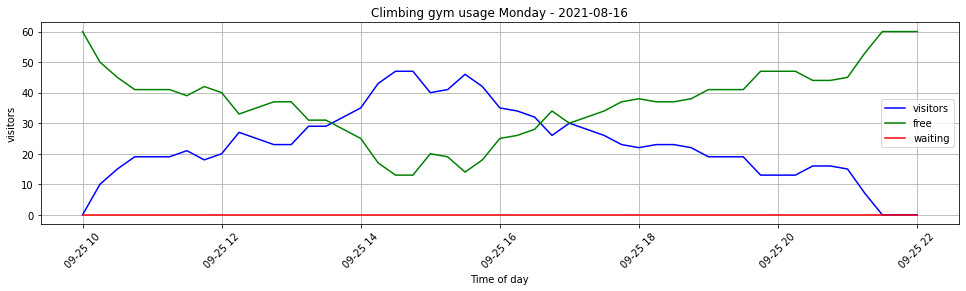

In [6]:
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot2grid((1,1), (0,0))
plt.plot_date(timestamps, visitors,'b-', label='visitors')
plt.plot_date(timestamps, free,'g-', label='free')
plt.plot_date(timestamps, waiting,'r-', label='waiting')
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)
ax1.grid(True)

plt.xlabel('Time of day')
plt.ylabel('visitors')
plt.title('Climbing gym usage Monday - 2021-08-16')
plt.legend()
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

This plot is useful to check the visitors during one single day. However we are interested in usage over the course of weeks and month. So lets load the visitor data of all available days.

In [7]:
all_guests = []
for folder in os.listdir("./data/"):
    guests = load_guests(folder)
    all_guests = all_guests + guests

In [8]:
all_guests[:5]

[{'timestamp': 1633618801, 'visitors': 48, 'waiting': 0, 'free': 9952},
 {'timestamp': 1633632301, 'visitors': 79, 'waiting': 0, 'free': 9921},
 {'timestamp': 1633594502, 'visitors': 0, 'waiting': 0, 'free': 10000},
 {'timestamp': 1633612501, 'visitors': 19, 'waiting': 0, 'free': 9981},
 {'timestamp': 1633625101, 'visitors': 72, 'waiting': 0, 'free': 9928}]

We are using the same function `prepare_data` again to prepare the data for plotting. This time we don't care about the ordering and some other fields, because `pandas` handles this quite well. So the function could skip the sorting. But its easier to just reuse the existing code.

In [9]:
visitors, waiting, free, timestamps, time_of_day, dates, days = prepare_data(all_guests)

Next we load the data to `pandas`. We drop the columns `dates`, `free` and `waiting` because we don't need them for the first heatmap. Later I may also use this data as well:

In [10]:
d = {'visitors': visitors, 'time_of_day': time_of_day, 'dates': dates, 'days': days }
df = pd.DataFrame(data=d)

In [11]:
df[:5]

,visitors,time_of_day,dates,days
0,37,14:15,20210808,Sun
1,39,14:30,20210808,Sun
2,39,14:45,20210808,Sun
3,36,15:00,20210808,Sun
4,39,15:15,20210808,Sun


Now we merge the two columns `dates` and `days` to a new column `dates_day`. This helps to read the y-axis in the heatmap better and compare diffrent weekdays.

In [12]:
df["dates_days"] = df.dates + " " + df.days

Next we have to pivot the data frame for easier plotting in a heatmap. We want to have data for each day as a row (`dates_days` column) and use the other columns for the time of day (`time_of_day` column which merges HH:MM into a string).

In [13]:
df_pivot = df.pivot(index='dates_days', columns='time_of_day', values='visitors')

In [14]:
df_pivot[:5]

time_of_day,10:00,10:15,10:30,10:45,11:00,11:15,11:30,11:45,12:00,12:15,...,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45,22:00
dates_days,,,,,,,,,,,,,,,,,,,,,
20210808 Sun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.0,28.0,27.0,14.0,14.0,10.0,9.0,9.0,9.0,0.0
20210809 Mon,5.0,11.0,15.0,19.0,19.0,20.0,23.0,24.0,28.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,24.0,22.0
20210810 Tue,0.0,6.0,9.0,18.0,24.0,28.0,34.0,34.0,33.0,29.0,...,NaN,NaN,NaN,50.0,44.0,38.0,31.0,25.0,25.0,22.0
20210811 Wed,22.0,7.0,11.0,12.0,15.0,17.0,18.0,18.0,21.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20210812 Thu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,13.0,...,NaN,NaN,NaN,NaN,34.0,29.0,11.0,11.0,11.0,11.0


Due to missing error handling and testing some data is missing (`NaN`). We just fill the missing data with the maximum capacity for now. Most of the missing data comes from errors in the scraper code. The code failed when the visitor capacity was at maximum and some expected `int` values were `-` strings.

In [15]:
df_pivot.loc[:] =  np.nan_to_num(df_pivot, nan=60)

Now we can plot the heatmap:

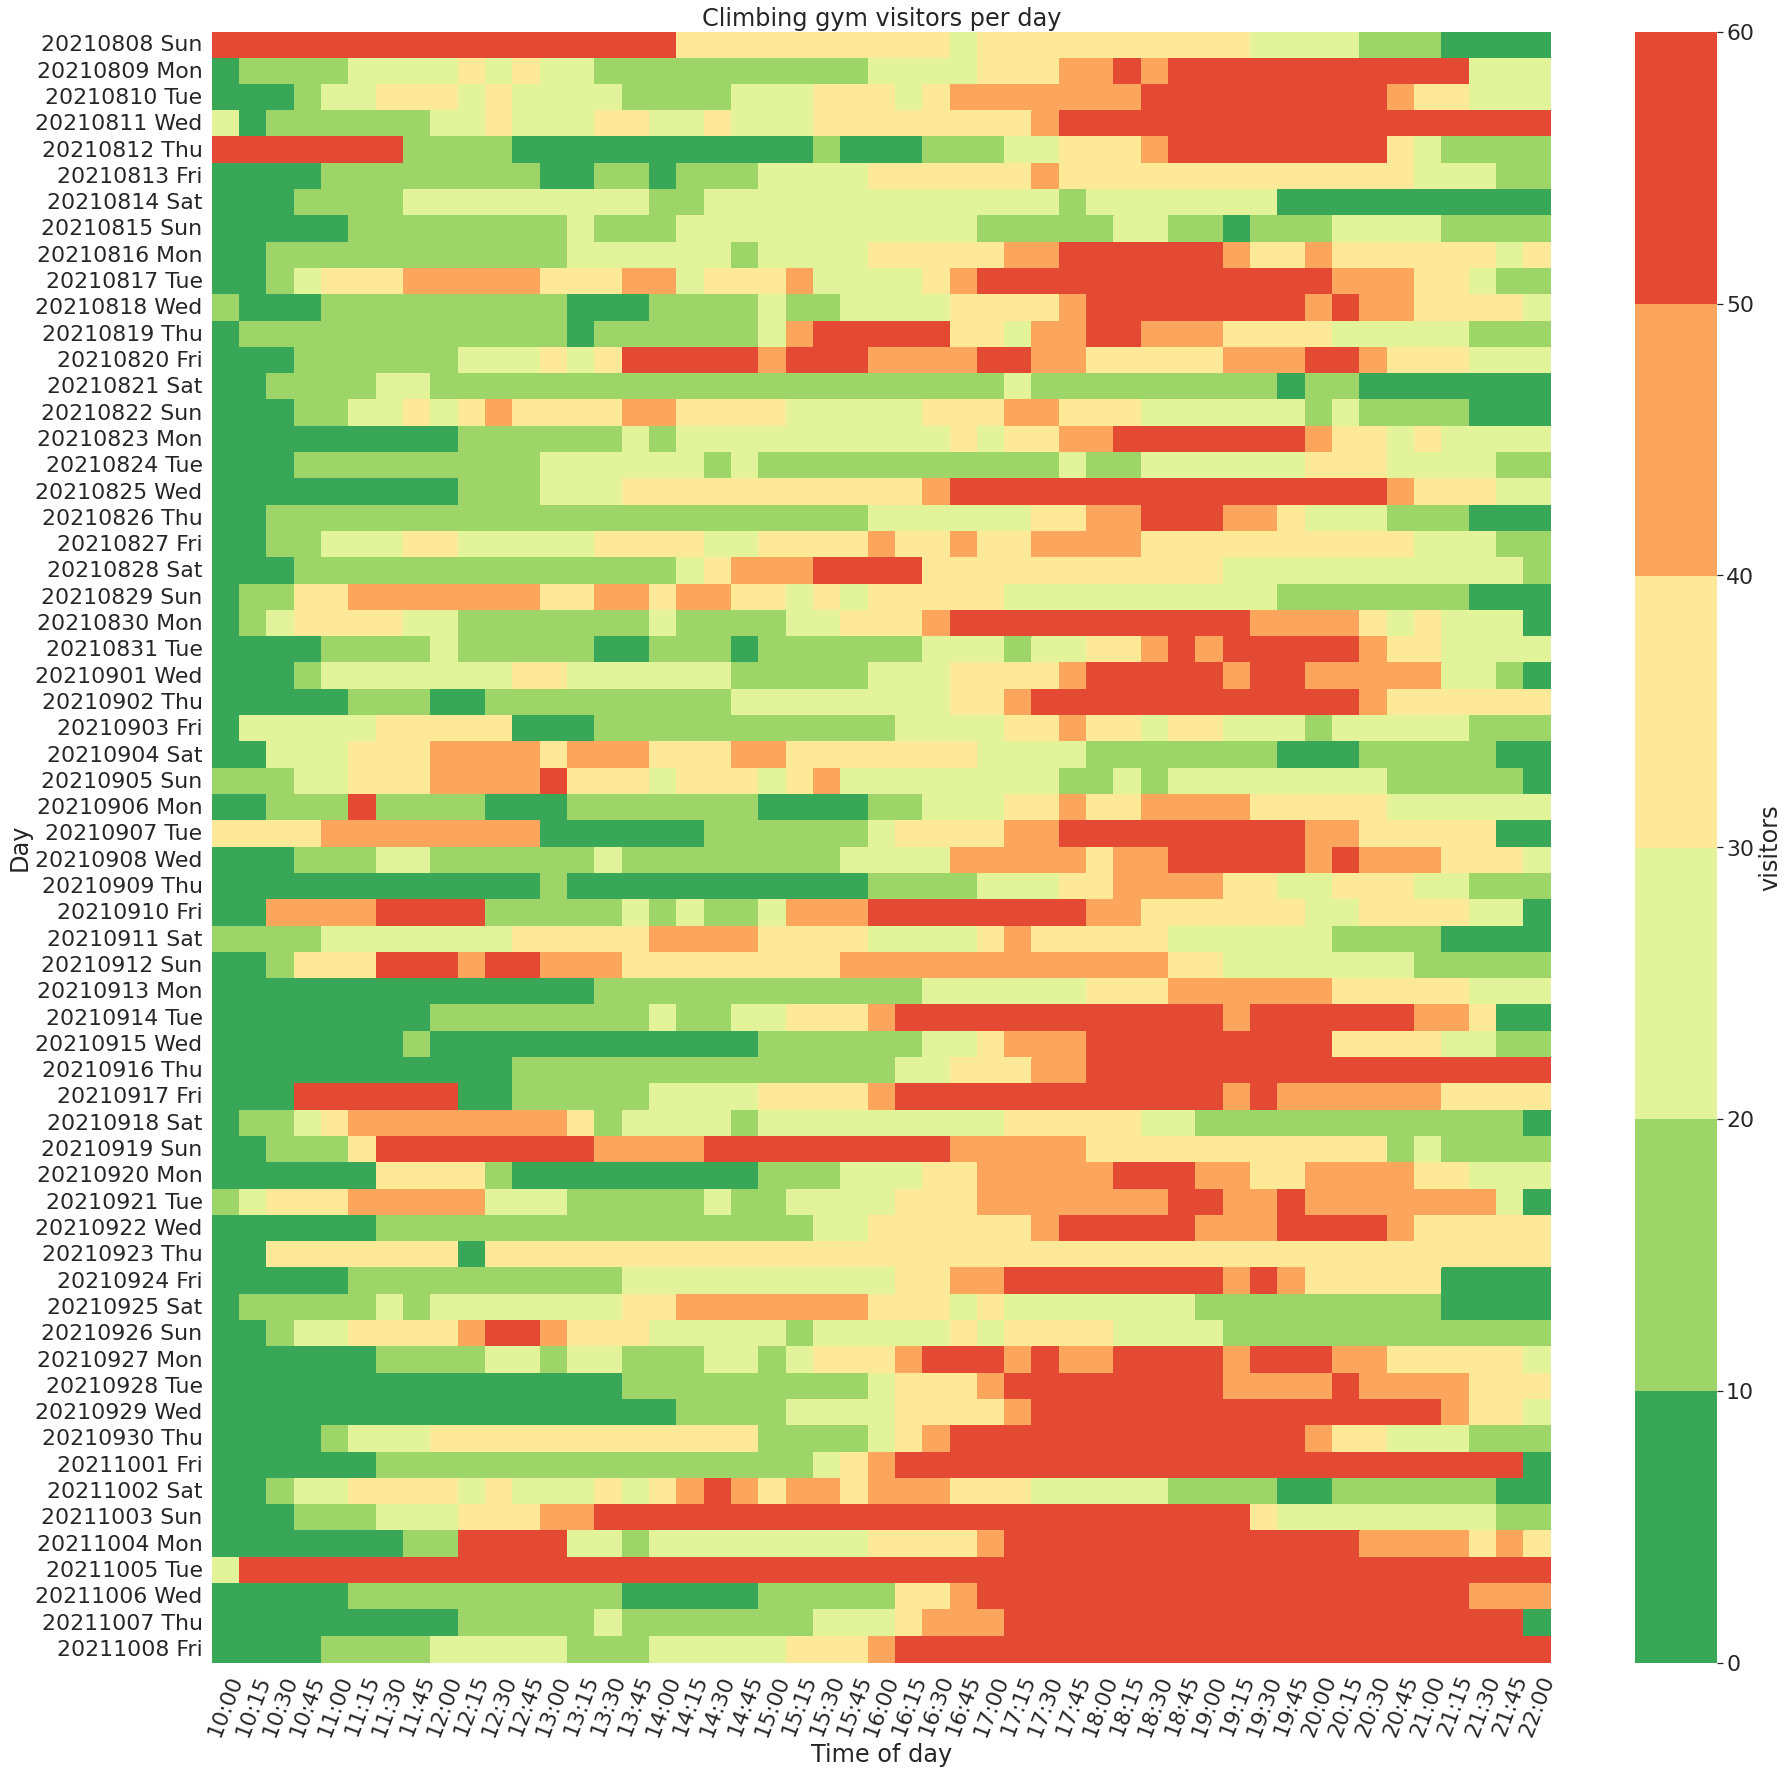

In [16]:
fig = plt.figure(figsize=(30,30))
sns.set(font_scale=2)
heatmap = sns.heatmap(df_pivot, cmap=sns.color_palette("RdYlGn_r"), cbar_kws={'label': 'visitors'}, vmin=0, vmax=60)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=69) 
plt.xlabel('Time of day')
plt.ylabel('Day')
plt.title('Climbing gym visitors per day')
plt.show()


It would be also interesting to know the average usage over the course of a week. To calculate this average usage we pivot the data similar to the first pivot. But this time we use `days` column as the index. We also tell pandas to aggregate all similar rows (meaning similar days) using the `np.mean` function.

In [17]:
df_pivot = df.pivot_table(index='days', columns='time_of_day', values='visitors', aggfunc = { 'visitors': np.mean })

In [18]:
df_pivot

time_of_day,10:00,10:15,10:30,10:45,11:00,11:15,11:30,11:45,12:00,12:15,...,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45,22:00
days,,,,,,,,,,,,,,,,,,,,,
Fri,1.222222,5.777778,13.555556,22.555556,23.666667,25.333333,28.000000,28.666667,29.333333,22.444444,...,45.222222,44.444444,45.444444,44.333333,42.333333,38.777778,33.111111,31.222222,30.000,18.111111
Mon,0.777778,5.555556,9.666667,11.777778,12.333333,13.500000,17.666667,16.888889,16.222222,22.888889,...,45.625000,43.875000,41.000000,38.875000,35.375000,33.750000,31.375000,28.111111,26.000,23.000000
Sat,1.625000,8.500000,14.875000,18.125000,21.000000,24.750000,26.750000,27.500000,27.625000,27.875000,...,14.625000,15.000000,13.875000,14.875000,14.750000,13.500000,11.250000,9.250000,7.250,5.250000
Sun,1.625000,5.500000,12.250000,19.500000,22.375000,28.625000,34.250000,36.750000,38.125000,39.250000,...,23.111111,23.000000,22.777778,21.000000,17.888889,17.000000,15.333333,13.888889,11.000,9.000000
Thu,0.125000,3.750000,9.875000,11.000000,12.875000,14.875000,15.625000,15.000000,15.222222,11.888889,...,45.428571,46.250000,42.142857,38.571429,35.375000,31.875000,29.000000,26.625000,25.125,14.375000
Tue,8.000000,14.111111,18.444444,22.111111,25.000000,27.222222,30.000000,31.555556,32.111111,31.777778,...,48.857143,47.571429,48.000000,44.625000,41.000000,37.375000,34.375000,30.375000,16.750,13.375000
Wed,4.666667,2.777778,6.222222,8.333333,9.888889,12.333333,14.555556,14.888889,14.111111,14.777778,...,55.428571,54.000000,53.000000,51.750000,47.875000,43.875000,35.750000,33.625000,29.250,23.750000


One last step is to adjust the order of the rows to represent a week:

In [19]:
sorter = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df_pivot = df_pivot.loc[sorter]

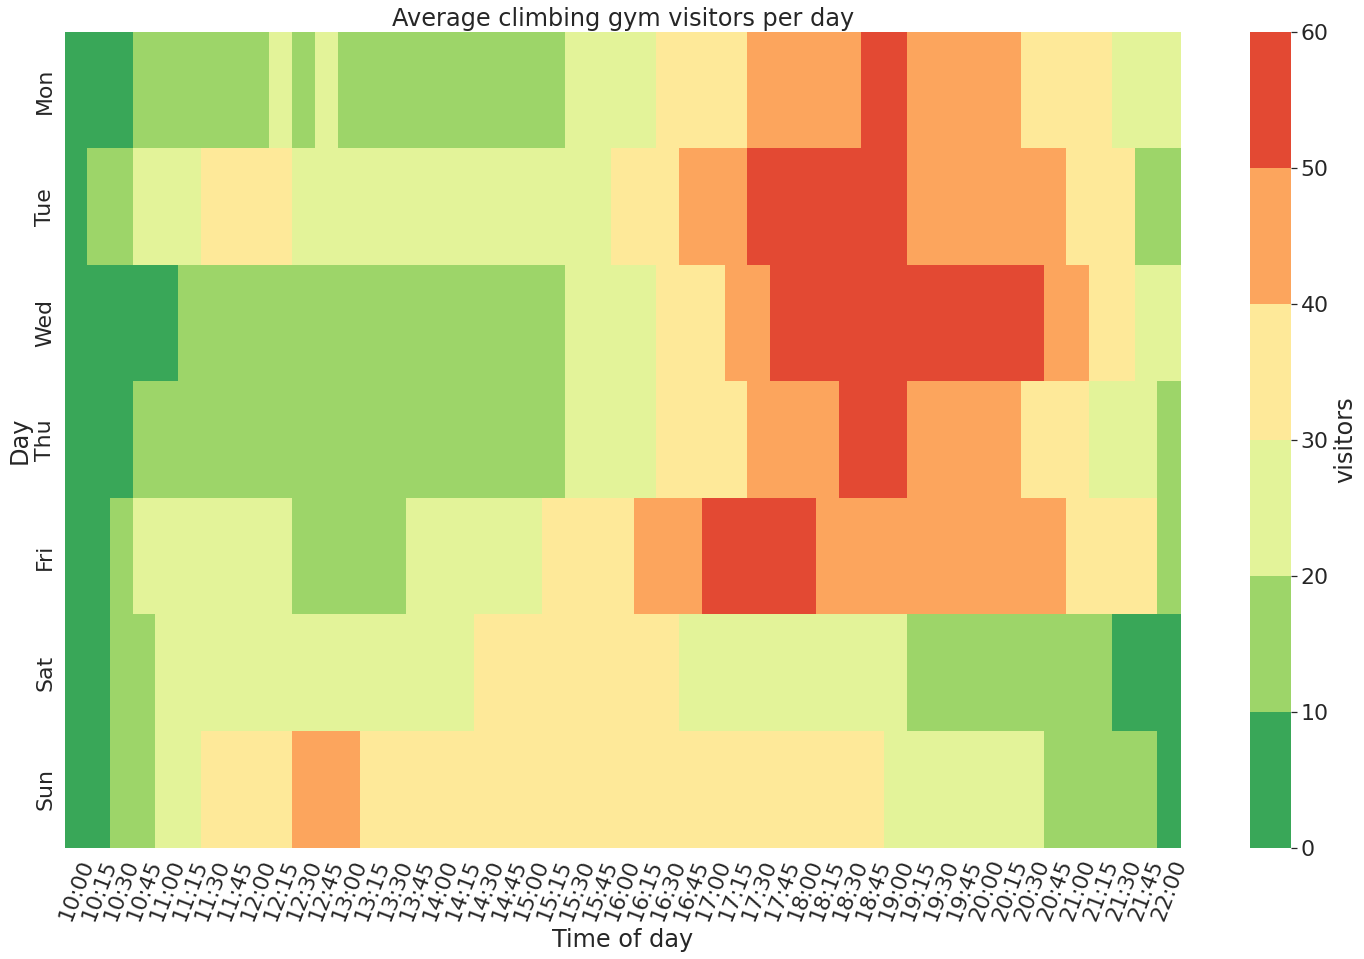

In [20]:
fig = plt.figure(figsize=(25,15))
sns.set(font_scale=2)
heatmap = sns.heatmap(df_pivot, cmap=sns.color_palette("RdYlGn_r"), cbar_kws={'label': 'visitors'}, vmin=0, vmax=60)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=69) 
plt.xlabel('Time of day')
plt.ylabel('Day')
plt.title('Average climbing gym visitors per day')
plt.show()